# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/cherry-leaves/train",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/cherry-leaves/test",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4205 files belonging to 2 classes.
==========================Validation Data====================
Found 1574 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/cherry-leaves/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/cherry-leaves/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4205 images belonging to 2 classes.
Found 1574 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 24 23:01:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               40W /  N/A|   4659MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_DIY_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9258
Epoch 1: val_accuracy improved from -inf to 0.98221, saving model to Cherry_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Non_Augmented\assets


211/211 [==============================] - 14s 51ms/step - loss: 0.1907 - accuracy: 0.9258 - val_loss: 0.0658 - val_accuracy: 0.9822 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9917
Epoch 2: val_accuracy improved from 0.98221 to 0.99555, saving model to Cherry_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Non_Augmented\assets


211/211 [==============================] - 10s 49ms/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.0129 - val_accuracy: 0.9956 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9926
Epoch 3: val_accuracy improved from 0.99555 to 1.00000, saving model to Cherry_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Non_Augmented\assets


211/211 [==============================] - 11s 50ms/step - loss: 0.0208 - accuracy: 0.9926 - val_loss: 0.0042 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
210/211 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9962
Epoch 4: val_accuracy did not improve from 1.00000
211/211 [==============================] - 9s 41ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 7.6747e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
210/211 [============================>.] - ETA: 0s - loss: 2.1046e-05 - accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 1.00000
211/211 [==============================] - 8s 40ms/step - loss: 2.0995e-05 - accuracy: 1.0000 - val_loss: 1.0714e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
210/211 [============================>.] - ETA: 0s - loss: 5.6048e-06 - accuracy: 1.0000
Epoch 6: val_accuracy did not improve from 1.00000
211/211 [==============================] - 8s 39ms/step - loss: 5.5827e-06 - accuracy: 1.0000 - val_

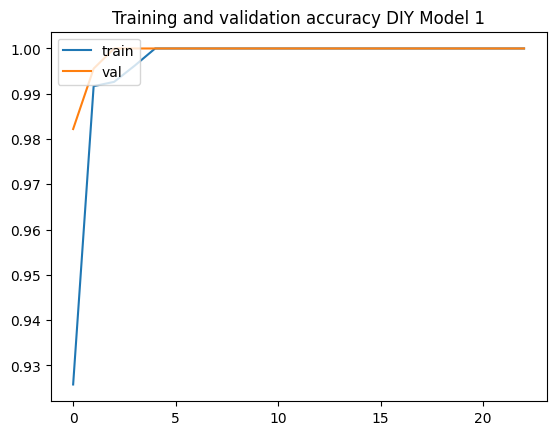

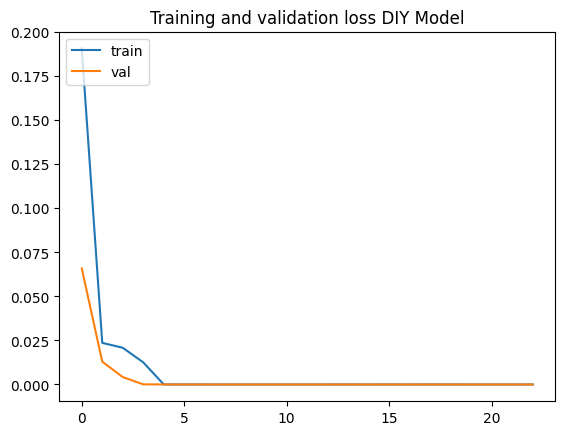

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_DIY_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8954
Epoch 1: val_accuracy improved from -inf to 0.97713, saving model to Cherry_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


211/211 [==============================] - 14s 65ms/step - loss: 0.2742 - accuracy: 0.8954 - val_loss: 0.0861 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 2/100
210/211 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9883
Epoch 2: val_accuracy improved from 0.97713 to 0.98412, saving model to Cherry_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


211/211 [==============================] - 13s 61ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.0531 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 3/100
210/211 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9892
Epoch 3: val_accuracy improved from 0.98412 to 0.99873, saving model to Cherry_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


211/211 [==============================] - 13s 64ms/step - loss: 0.0335 - accuracy: 0.9893 - val_loss: 0.0026 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 4/100
211/211 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9983
Epoch 4: val_accuracy did not improve from 0.99873
211/211 [==============================] - 10s 46ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0027 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 5/100
211/211 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9867
Epoch 5: val_accuracy improved from 0.99873 to 1.00000, saving model to Cherry_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Non_Augmented\assets


211/211 [==============================] - 14s 67ms/step - loss: 0.0339 - accuracy: 0.9867 - val_loss: 6.9312e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
210/211 [============================>.] - ETA: 0s - loss: 5.6391e-04 - accuracy: 0.9998
Epoch 6: val_accuracy did not improve from 1.00000
211/211 [==============================] - 10s 47ms/step - loss: 5.6136e-04 - accuracy: 0.9998 - val_loss: 4.4515e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
211/211 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9955
Epoch 7: val_accuracy did not improve from 1.00000
211/211 [==============================] - 10s 46ms/step - loss: 0.0131 - accuracy: 0.9955 - val_loss: 0.0288 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 8/100
211/211 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9981
Epoch 8: val_accuracy did not improve from 1.00000
211/211 [==============================] - 10s 46ms/step - loss: 0.0044 - accuracy: 0.9981 - val_loss:

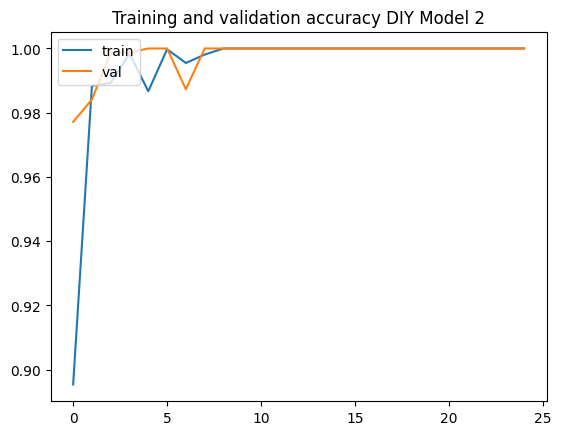

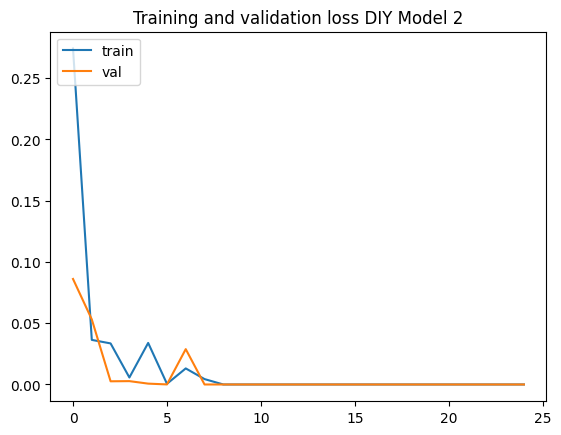

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')